<a href="https://colab.research.google.com/github/jash0803/ai-for-social-good-acm-summer-school/blob/main/PINN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Making a learning algorithm physics-informed amounts to introducing appropriate observational, inductive, or learning biases that can steer the learning process towards identifying physically consistent solutions.

1. Observational bias (observational data → Underlying physical principles)

2. Inductive bias (prior assumptions tailored within ML model architecture)

3. Learning bias (modulate training phase to explicitly favour convergence towards physics adhering solutions.)

# A Teaser Example

## Purely Data Driven

Epoch 10/50, Loss: 0.100622
Epoch 20/50, Loss: 0.100606
Epoch 30/50, Loss: 0.100611
Epoch 40/50, Loss: 0.100610
Epoch 50/50, Loss: 0.100574


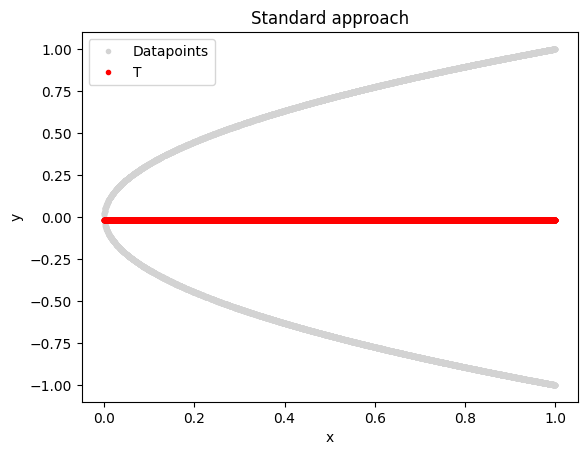

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate data
N = 10000
X = np.random.random(N).astype(np.float32).reshape(-1, 1)

# Generation of Y-Data
sign = (- np.ones((N,))).astype(np.float32) ** np.random.randint(2, size=N)
Y = (np.sqrt(X.flatten()) * sign).reshape(-1, 1).astype(np.float32)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
Y_tensor = torch.tensor(Y)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, hiddendim=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, hiddendim)
        self.fc2 = nn.Linear(hiddendim, hiddendim)
        self.fc3 = nn.Linear(hiddendim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Linear output
        return x

nn_sup = SimpleNN(hiddendim=128)
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_sup.parameters(), lr=0.001)

# Training loop
epochs = 50
batch_size = 5

for epoch in range(epochs):
    permutation = torch.randperm(N)
    epoch_loss = 0.0

    for i in range(0, N, batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_tensor[indices], Y_tensor[indices]

        optimizer.zero_grad()
        outputs = nn_sup(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if(epoch%10==9): print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/N:.6f}")

plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
plt.plot(X, nn_sup(torch.tensor(X)).detach(), '.',label='T', color="red")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Standard approach')
plt.legend()
plt.show()

## Physics-Informed

Epoch 10/50, Loss: 0.000005
Epoch 20/50, Loss: 0.000006
Epoch 30/50, Loss: 0.000001
Epoch 40/50, Loss: 0.000004
Epoch 50/50, Loss: 0.000001


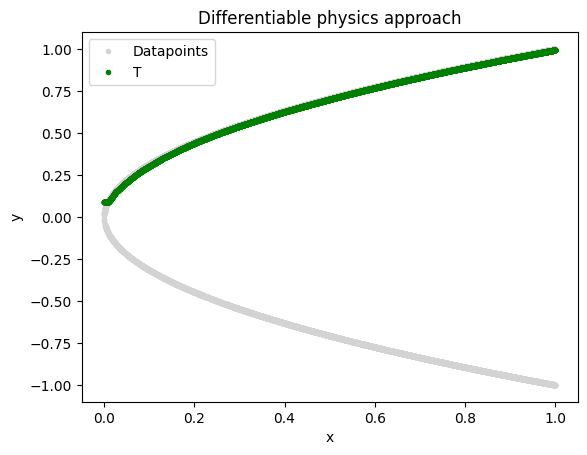

In [ ]:
# X-Data
# X = X , we can directly re-use the X from above, nothing has changed...

# P maps Y back to X, simply by computing a square, as y is a TF tensor input, the square operation **2 will be differentiable
def P(y):
    return torch.square(y)

# Define custom loss function using the "physics" operator P
def loss_function(y_true, y_pred):
    return criterion(y_true, P(y_pred))

nn_dp = SimpleNN(hiddendim=128)
optimizer = optim.Adam(nn_dp.parameters(), lr=0.001)

# Training loop
batch_size = 5

for epoch in range(epochs):
    permutation = torch.randperm(N)
    epoch_loss = 0.0

    for i in range(0, N, batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_tensor[indices]

        optimizer.zero_grad()
        outputs = nn_dp(batch_x)
        loss = loss_function(batch_x, outputs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if(epoch%10==9): print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/N:.6f}")

# Results
plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
plt.plot(X, nn_dp(torch.tensor(X)).detach(), '.',label='T', color="green")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differentiable physics approach')
plt.legend()
plt.show()

# Another Example

## Purely Data Driven

<center>
<img src="https://towardsdatascience.com/wp-content/uploads/2022/10/1GqNSRT9ShlTWv9TySXGxsg.gif"/>
</center>

## Physics-informed

<center>
<img src="https://towardsdatascience.com/wp-content/uploads/2022/10/1VqL26_35X-_4X_OuGyz74A.png"/>
</center>


# Understanding PINNs through Hands-On

## Minimal Example of PINNs

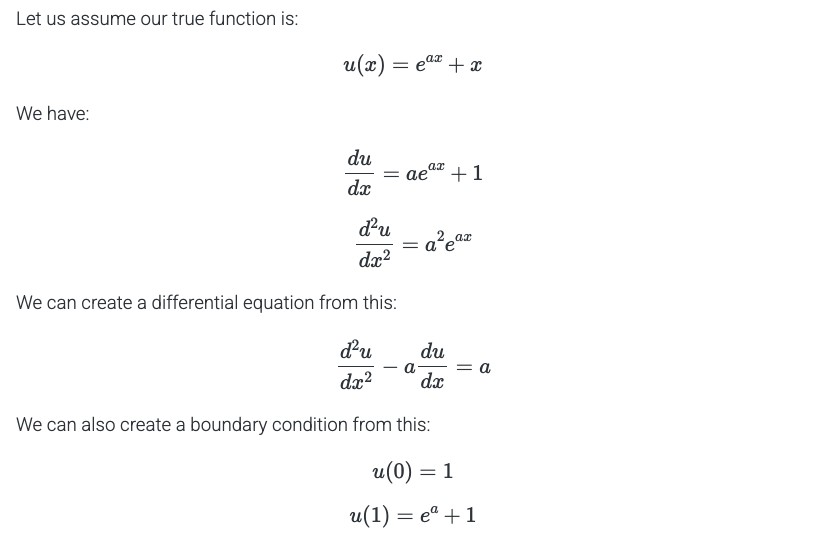

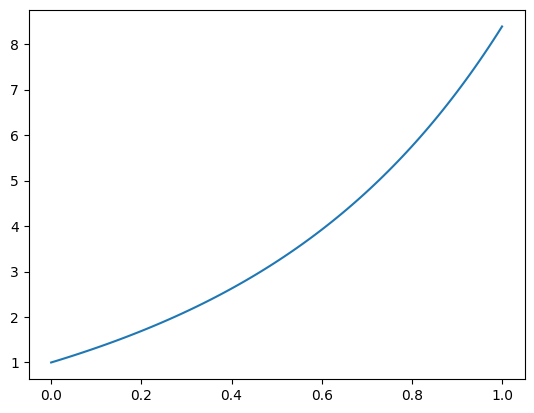

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

x_lin = torch.linspace(0, 1, 100)
a = 2
u_true = torch.e**(a*x_lin) + x_lin

plt.plot(x_lin, u_true)

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_input=1, n_hidden=5, n_output=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = self.fc3(x)
        return x
u_model = MLP(n_hidden=32)

In [ ]:
# Let us compute du/dx for any x vector

x_vec = torch.randn(10, 1, requires_grad=True)
u_vec = u_model(x_vec)
print(u_vec)

tensor([[-0.1359],
        [-0.0891],
        [ 0.0318],
        [-0.1640],
        [ 0.0160],
        [-0.0898],
        [-0.0743],
        [ 0.0283],
        [-0.0569],
        [-0.2610]], grad_fn=<AddmmBackward0>)


In [ ]:
du_dx  = torch.autograd.grad(
    u_vec, # Whose gradient we want
    x_vec, # WRT what we want the gradient
    torch.ones_like(u_vec), # Shape of the gradient
    create_graph=True)[0] # We want to differentiate again
du_dx

tensor([[0.1631],
        [0.1633],
        [0.1203],
        [0.1599],
        [0.1305],
        [0.1634],
        [0.1618],
        [0.1228],
        [0.1588],
        [0.1351]], grad_fn=<MmBackward0>)

In [ ]:
# Now, let us compute d2u/dx2 for any x vector

x_vec = torch.randn(10, 1, requires_grad=True)
u_vec = u_model(x_vec)
du_dx  = torch.autograd.grad(
    u_vec, # Whose gradient we want
    x_vec, # WRT what we want the gradient
    torch.ones_like(u_vec), # Shape of the gradient
    create_graph=True)[0] # We want to differentiate again

d2u_dx2  = torch.autograd.grad(
    du_dx, # Whose gradient we want
    x_vec, # WRT what we want the gradient
    torch.ones_like(du_dx), # Shape of the gradient
    create_graph=True)[0] # We want to differentiate again
d2u_dx2

tensor([[-0.0072],
        [ 0.0090],
        [-0.0094],
        [ 0.0077],
        [ 0.0426],
        [-0.0190],
        [ 0.0505],
        [-0.0799],
        [-0.0062],
        [-0.0418]], grad_fn=<MmBackward0>)

In [ ]:
def pde_loss(model, x):
    u = model(x)
    du_dx = torch.autograd.grad(
        u, # Whose gradient we want
        x, # WRT what we want the gradient
        torch.ones_like(u), # Shape of the gradient
        create_graph=True)[0] # We want to differentiate again
    d2u_dx2 = torch.autograd.grad(
        du_dx, # Whose gradient we want
        x, # WRT what we want the gradient
        torch.ones_like(du_dx), # Shape of the gradient
        create_graph=True)[0] # We want to differentiate again

    # Our PDE is d2u/dx2 -a*du/dx = a
    # Loss = (d2u/dx2 -a*du/dx - a)**2
    loss = (d2u_dx2 - a*du_dx - a)**2
    return loss.mean()

# Boundary loss
def boundary_loss(model):
    # Boundary condition u(0) = 1
    x = torch.tensor([[0.0]])
    u = model(x)
    loss = (u - 1)**2

    # Boundary condition u(1) = e^a + 1
    x = torch.tensor([[1.0]])
    u = model(x)
    loss += (u - torch.e**(a) - 1)**2
    return loss.mean()

In [ ]:
# Training loop
u_model = MLP(n_hidden=32)

optimizer = torch.optim.Adam(u_model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    x_vec = torch.rand((400, 1), requires_grad=True)
    loss = pde_loss(u_model, x_vec) + boundary_loss(u_model)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(epoch, loss.item()))

Epoch: 0, Loss: 74.7644
Epoch: 500, Loss: 1.8221
Epoch: 1000, Loss: 0.0901
Epoch: 1500, Loss: 0.0370
Epoch: 2000, Loss: 0.0204
Epoch: 2500, Loss: 0.0180
Epoch: 3000, Loss: 0.0093
Epoch: 3500, Loss: 0.0073
Epoch: 4000, Loss: 0.0057
Epoch: 4500, Loss: 0.0054
Epoch: 5000, Loss: 0.0051
Epoch: 5500, Loss: 0.0043
Epoch: 6000, Loss: 0.0060
Epoch: 6500, Loss: 0.0020
Epoch: 7000, Loss: 0.0019
Epoch: 7500, Loss: 0.0018
Epoch: 8000, Loss: 0.0017
Epoch: 8500, Loss: 0.0018
Epoch: 9000, Loss: 0.0013
Epoch: 9500, Loss: 0.0029


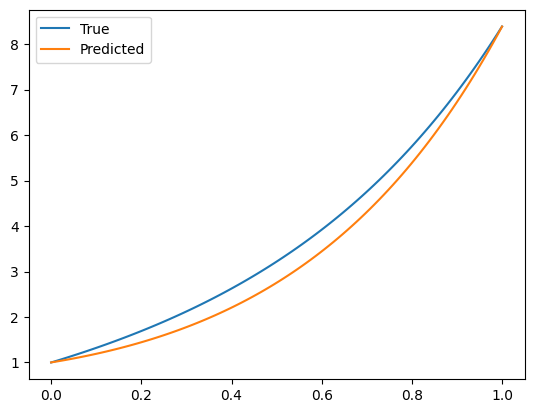

In [ ]:
# Plotting the results
x_lin = torch.linspace(0, 1, 100)
u_true = torch.e**(a*x_lin) +   x_lin
u_pred = u_model(x_lin.unsqueeze(1)).cpu().detach()

plt.plot(x_lin.cpu(), u_true.cpu(), label="True")
plt.plot(x_lin.cpu(), u_pred, label="Predicted")
plt.legend()

## Training for a variable without Data

### Example 1

Mean water balance residual (ground truth): 3.079018521627101e-15
Epoch 0: Total Loss = 3.669e+02, Data Loss = 1.747e+02, Physics Loss = 1.922e+02
Epoch 1000: Total Loss = 1.548e+01, Data Loss = 1.086e+01, Physics Loss = 4.613e+00
Epoch 2000: Total Loss = 7.576e+00, Data Loss = 5.765e+00, Physics Loss = 1.810e+00
Epoch 3000: Total Loss = 5.154e+00, Data Loss = 3.882e+00, Physics Loss = 1.272e+00
Epoch 4000: Total Loss = 3.998e+00, Data Loss = 2.926e+00, Physics Loss = 1.072e+00
Epoch 5000: Total Loss = 3.260e+00, Data Loss = 2.329e+00, Physics Loss = 9.314e-01
Epoch 6000: Total Loss = 2.621e+00, Data Loss = 1.864e+00, Physics Loss = 7.577e-01
Epoch 7000: Total Loss = 1.664e+00, Data Loss = 1.173e+00, Physics Loss = 4.913e-01
Epoch 8000: Total Loss = 9.836e-01, Data Loss = 6.680e-01, Physics Loss = 3.156e-01
Epoch 9000: Total Loss = 5.722e-01, Data Loss = 4.015e-01, Physics Loss = 1.707e-01
Epoch 10000: Total Loss = 3.351e-01, Data Loss = 2.393e-01, Physics Loss = 9.580e-02
Epoch 11000:

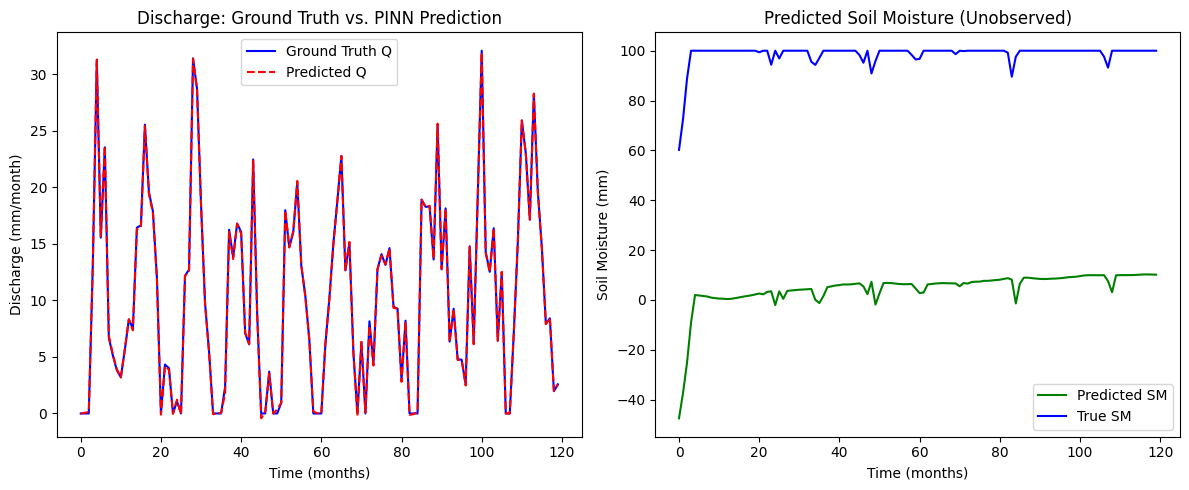

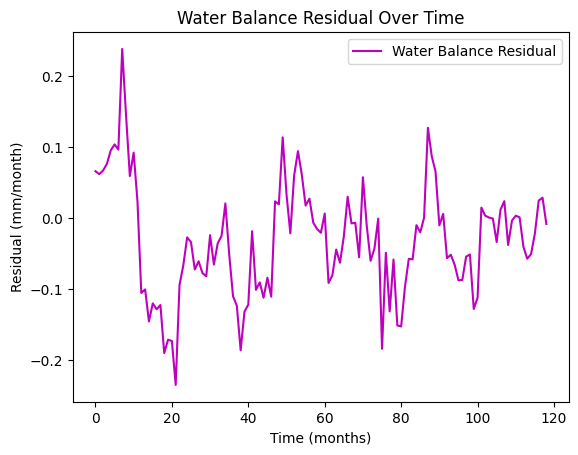

In [ ]:
"""
PINN for Hydrological Modeling with a Water Balance Constraint

Overview:
1. Generate synthetic precipitation (P) and PET input data for 10 years (monthly time steps).
2. Assume ground-truth parameters for a simplified SIMHYD model to generate soil moisture (SM) and
   discharge (Q) time series while satisfying water balance.
3. Show that the water balance is satisfied:
       P - PET = (ΔSM) + Q.
4. Assume that ground truth for SM is not available; only Q is observed.
5. Set up a PINN that accepts [t, P, PET] as input and outputs [SM, Q]. During training, use:
      • Data loss on Q (comparison with ground truth).
      • Physics loss that enforces the water balance constraint on SM.
6. Train the model and visualize predictions, including evaluation of the water balance residual.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ============
# 1. Synthetic Data Generation
# ============

# Define simulation parameters
T_years = 10                       # number of years
months_per_year = 12
T_total = T_years * months_per_year  # total time steps (e.g., 120 months)
t_array = np.arange(T_total)         # time indices: 0, 1, 2, ..., 119
# Normalize time to [0,1] for neural network input
t_norm = t_array / (T_total - 1)

# Generate synthetic precipitation (P) and PET with seasonal variation and noise.
# Units: mm/month.
P_mean = 50.0
P_amp = 20.0
PET_mean = 40.0
PET_amp = 15.0

# Create a seasonal cycle with period = 12 months.
season = 2 * np.pi * (t_array % months_per_year) / months_per_year

# Introduce some random noise.
np.random.seed(0)
P = P_mean + P_amp * np.sin(season) + np.random.normal(0, 5, size=T_total)
PET = PET_mean + PET_amp * np.sin(season + np.pi/6) + np.random.normal(0, 3, size=T_total)

# ============
# 2. Ground Truth Generation Using a Simplified SIMHYD-Type Water Balance Model
# ============

# We define a simple water balance where:
#     SM[t+1] = min(SM[t] + P[t] - PET[t], Smax)
#     Q[t]    = max(SM[t] + P[t] - PET[t] - Smax, 0)
# This formulation implies that any surplus beyond the soil capacity Smax is discharged.
Smax = 100.0  # maximum soil moisture storage (mm)

SM_true = np.zeros(T_total + 1)  # Soil moisture at each time step (plus one extra for t+1)
Q_true = np.zeros(T_total)       # Discharge at each time step

# Assume an initial soil moisture of half capacity.
SM_true[0] = Smax / 2

# Iterate over each time step to update soil moisture and compute discharge.
for t in range(T_total):
    available = SM_true[t] + (P[t] - PET[t])
    Q_true[t] = max(available - Smax, 0)       # Discharge: excess water when storage exceeds capacity.
    SM_true[t+1] = min(available, Smax)          # Soil moisture cannot exceed Smax.

# ============
# 3. Verify Water Balance
# ============

# For each time step, water balance (mass conservation) is given by:
#     P[t] - PET[t] = (SM_true[t+1] - SM_true[t]) + Q_true[t]
wb_residual = (P - PET) - ((SM_true[1:] - SM_true[:-1]) + Q_true)
print("Mean water balance residual (ground truth):", np.mean(np.abs(wb_residual)))
# A near-zero value confirms that water balance holds.

# ============
# 4. Prepare Training Data (Assuming SM is Unobserved)
# ============

# The neural network will use input features: [normalized time, P, PET].
# Ground truth Q is available, but ground truth SM is assumed to be missing during training.
X = np.column_stack([t_norm, P, PET])  # shape: (T_total, 3)

# We design the output as two channels: [SM, Q].
# We only provide ground truth for the Q component.
Y_data = np.zeros((T_total, 2))
Y_data[:, 1] = Q_true  # Only discharge (Q) is used in the data loss.

# Convert arrays to PyTorch tensors.
X_tensor = torch.tensor(X, dtype=torch.float32)            # (T_total, 3)
Y_Q_tensor = torch.tensor(Q_true.reshape(-1, 1), dtype=torch.float32)  # (T_total, 1)

# ============
# 5. Define the PINN Model and Loss Functions
# ============

# Define a simple feedforward network that maps [t, P, PET] to [SM, Q].
class HydroPINN(nn.Module):
    def __init__(self):
        super(HydroPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2)  # outputs: first element = SM, second element = Q.
        )
    def forward(self, x):
        return self.net(x)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HydroPINN()#.to(device)

# Data loss: Only enforce the mismatch between predicted and true Q.
def data_loss(pred, Q_true):
    # pred: tensor of shape (batch, 2); we compare the second channel.
    Q_pred = pred[:, 1:2]
    return torch.mean((Q_pred - Q_true) ** 2)

# Physics loss: Enforce the water balance equation.
# For discrete time steps (t = 0,...,T_total-2), the balance is:
#    P[t] - PET[t] = (SM[t+1] - SM[t]) + Q[t]
def physics_loss(model, X, P, PET):
    # Predict outputs for all T_total time steps.
    pred = model(X)                   # (T_total, 2)
    SM_pred = pred[:, 0:1]            # predicted soil moisture
    Q_pred = pred[:, 1:2]             # predicted discharge

    # Compute changes in predicted soil moisture between consecutive time steps.
    dSM = SM_pred[1:] - SM_pred[:-1]   # (T_total-1, 1)

    # For t = 0,..., T_total-2, form the water balance residual.
    # We use the original (numpy) P and PET arrays (for t=0 to T_total-2) and convert them.
    P_tensor = torch.tensor(P[:-1].reshape(-1, 1), dtype=torch.float32)
    PET_tensor = torch.tensor(PET[:-1].reshape(-1, 1), dtype=torch.float32)
    # Note: Q_pred[:-1] corresponds to time steps 0 to T_total-2.
    wb_res = (P_tensor - PET_tensor) - (dSM + Q_pred[:-1])
    return torch.mean(wb_res ** 2)

# ============
# 6. Training the PINN
# ============

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20000
loss_history = []
lambda_phy = 1.0  # weight for the physics loss term

for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass: predict [SM, Q] for all time steps.
    pred = model(X_tensor)  # shape: (T_total, 2)

    # Compute data loss (only on Q).
    loss_d = data_loss(pred, Y_Q_tensor)

    # Compute physics loss (water balance constraint).
    loss_p = physics_loss(model, X_tensor, P, PET)

    # Total loss is a combination of the two.
    loss = loss_d + lambda_phy * loss_p
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.3e}, Data Loss = {loss_d.item():.3e}, Physics Loss = {loss_p.item():.3e}")

# ============
# 7. Visualization and Evaluation
# ============

# Get model predictions.
with torch.no_grad():
    pred_all = model(X_tensor).detach().numpy()
SM_pred = pred_all[:, 0]  # Predicted soil moisture time series
Q_pred = pred_all[:, 1]   # Predicted discharge time series

# Plot the ground truth vs. predicted discharge (Q).
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_array, Q_true, 'b-', label="Ground Truth Q")
plt.plot(t_array, Q_pred, 'r--', label="Predicted Q")
plt.xlabel("Time (months)")
plt.ylabel("Discharge (mm/month)")
plt.title("Discharge: Ground Truth vs. PINN Prediction")
plt.legend()

# Plot the predicted soil moisture (SM). (No ground truth is assumed during training.)
plt.subplot(1,2,2)
plt.plot(t_array, SM_pred, 'g-', label="Predicted SM")
plt.plot(t_array, SM_true[1:], 'b-', label = 'True SM')
plt.xlabel("Time (months)")
plt.ylabel("Soil Moisture (mm)")
plt.title("Predicted Soil Moisture (Unobserved)")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate and visualize the water balance residual for the PINN predictions.
SM_pred_tensor = torch.tensor(SM_pred.reshape(-1,1), dtype=torch.float32)
Q_pred_tensor = torch.tensor(Q_pred.reshape(-1,1), dtype=torch.float32)
dSM_pred = SM_pred_tensor[1:] - SM_pred_tensor[:-1]

P_tensor = torch.tensor(P[:-1].reshape(-1,1), dtype=torch.float32)
PET_tensor = torch.tensor(PET[:-1].reshape(-1,1), dtype=torch.float32)
wb_residual_pred = (P_tensor - PET_tensor) - (dSM_pred + Q_pred_tensor[:-1])
wb_res_np = wb_residual_pred.detach().numpy()

plt.figure()
plt.plot(t_array[:-1], wb_res_np, 'm-', label="Water Balance Residual")
plt.xlabel("Time (months)")
plt.ylabel("Residual (mm/month)")
plt.title("Water Balance Residual Over Time")
plt.legend()
plt.show()


## Varieties in Physics-informed Problems

### Example 2

Epoch 0 - Total Loss: 8.344e-01, PDE Loss: 6.406e-05, IC Loss: 7.962e-01, BC Loss: 3.813e-02
Epoch 500 - Total Loss: 9.509e-02, PDE Loss: 3.131e-03, IC Loss: 5.296e-02, BC Loss: 3.900e-02
Epoch 1000 - Total Loss: 7.656e-03, PDE Loss: 5.002e-04, IC Loss: 1.474e-03, BC Loss: 5.682e-03
Epoch 1500 - Total Loss: 1.695e-03, PDE Loss: 1.892e-04, IC Loss: 1.581e-04, BC Loss: 1.348e-03
Epoch 2000 - Total Loss: 3.446e-04, PDE Loss: 7.699e-05, IC Loss: 1.362e-05, BC Loss: 2.540e-04
Epoch 2500 - Total Loss: 1.898e-04, PDE Loss: 4.442e-05, IC Loss: 1.022e-05, BC Loss: 1.351e-04
Epoch 3000 - Total Loss: 4.490e-04, PDE Loss: 9.115e-05, IC Loss: 1.168e-04, BC Loss: 2.411e-04
Epoch 3500 - Total Loss: 8.814e-05, PDE Loss: 2.666e-05, IC Loss: 5.347e-06, BC Loss: 5.613e-05
Epoch 4000 - Total Loss: 6.601e-05, PDE Loss: 2.417e-05, IC Loss: 3.787e-06, BC Loss: 3.805e-05
Epoch 4500 - Total Loss: 5.275e-05, PDE Loss: 2.108e-05, IC Loss: 3.600e-06, BC Loss: 2.806e-05


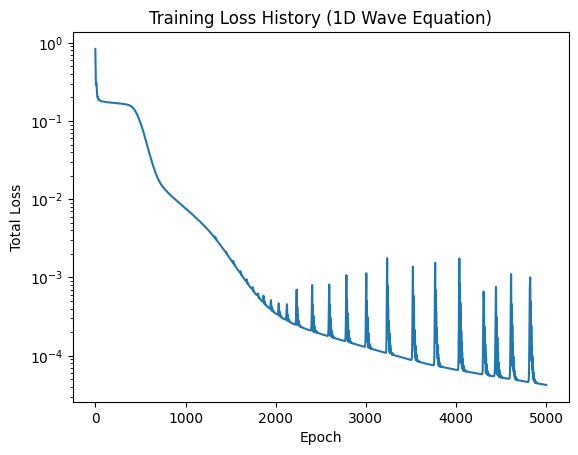

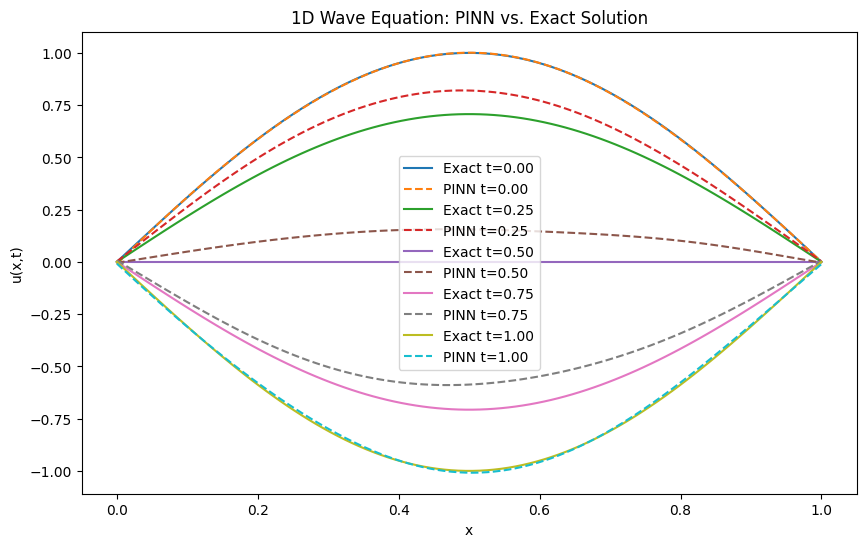

In [ ]:
"""
Forward Problem – Solving the 1D Wave Equation with PINNs in PyTorch

Equation:
    u_tt = c^2 * u_xx,  for (x, t) in [0,1]×[0,1]

Boundary Conditions:
    u(0,t) = 0,   u(1,t) = 0

Initial Conditions:
    u(x,0) = sin(pi*x)
    u_t(x,0) = 0

Exact Solution (when c=1):
    u(x,t) = sin(pi*x)*cos(pi*t)
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the neural network for u(x,t)
class WavePINN(nn.Module):
    def __init__(self):
        super(WavePINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = WavePINN()

# Wave speed
c = 1.0

# Exact solution for evaluation
def exact_wave_solution(x, t):
    return np.sin(np.pi * x) * np.cos(np.pi * t)

# Compute PDE residual using automatic differentiation
def compute_wave_residual(x, t):
    # Ensure x and t require gradients
    x.requires_grad = True
    t.requires_grad = True
    # Combine inputs into a tensor of shape (N,2)
    inputs = torch.cat([x, t], dim=1)
    u = model(inputs)

    # Compute time derivative: u_t and u_tt
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]

    # Compute spatial derivatives: u_x and u_xx
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual: u_tt - c^2 * u_xx = 0
    residual = u_tt - c**2 * u_xx
    return residual

# Training configuration
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000

# Collocation points for enforcing the PDE (interior domain)
N_f = 2000
x_f = np.random.uniform(0, 1, (N_f, 1))
t_f = np.random.uniform(0, 1, (N_f, 1))
x_f_tensor = torch.tensor(x_f, dtype=torch.float32)
t_f_tensor = torch.tensor(t_f, dtype=torch.float32)

# Initial condition: u(x,0) = sin(pi*x)
N_ic = 200
x_ic = np.linspace(0, 1, N_ic).reshape(-1,1)
t_ic = np.zeros_like(x_ic)
u_ic = np.sin(np.pi * x_ic)
x_ic_tensor = torch.tensor(x_ic, dtype=torch.float32)
t_ic_tensor = torch.tensor(t_ic, dtype=torch.float32)
u_ic_tensor = torch.tensor(u_ic, dtype=torch.float32)

# Boundary condition: u(0,t)=0 and u(1,t)=0
N_bc = 200
t_bc = np.linspace(0, 1, N_bc).reshape(-1,1)
x_bc_left = np.zeros_like(t_bc)
x_bc_right = np.ones_like(t_bc)
# Combine both boundaries
x_bc = np.vstack([x_bc_left, x_bc_right])
t_bc = np.vstack([t_bc, t_bc])
u_bc = np.zeros_like(x_bc)
x_bc_tensor = torch.tensor(x_bc, dtype=torch.float32)
t_bc_tensor = torch.tensor(t_bc, dtype=torch.float32)
u_bc_tensor = torch.tensor(u_bc, dtype=torch.float32)

loss_history = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # PDE residual loss from collocation points
    residual = compute_wave_residual(x_f_tensor, t_f_tensor)
    loss_pde = torch.mean(residual**2)

    # Initial condition loss: u(x,0) = sin(pi*x)
    input_ic = torch.cat([x_ic_tensor, t_ic_tensor], dim=1)
    u_pred_ic = model(input_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic_tensor)**2)

    # Boundary condition loss: u(0,t)=0 and u(1,t)=0
    input_bc = torch.cat([x_bc_tensor, t_bc_tensor], dim=1)
    u_pred_bc = model(input_bc)
    loss_bc = torch.mean(u_pred_bc**2)  # since the target is zero

    # Total loss
    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} - Total Loss: {loss.item():.3e}, PDE Loss: {loss_pde.item():.3e}, IC Loss: {loss_ic.item():.3e}, BC Loss: {loss_bc.item():.3e}")

# Plot loss history
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss History (1D Wave Equation)")
plt.show()

# Evaluate solution on a grid for visualization at different times
x_vals = np.linspace(0, 1, 100).reshape(-1,1)
t_vals = [0.0, 0.25, 0.5, 0.75, 1.0]

plt.figure(figsize=(10, 6))
for t in t_vals:
    x_tensor = torch.tensor(x_vals, dtype=torch.float32)
    t_tensor = torch.full_like(x_tensor, t)
    inp = torch.cat([x_tensor, t_tensor], dim=1)
    u_pred = model(inp).detach().numpy().flatten()
    u_exact = exact_wave_solution(x_vals, t).flatten()
    plt.plot(x_vals, u_exact, label=f'Exact t={t:.2f}')
    plt.plot(x_vals, u_pred, '--', label=f'PINN t={t:.2f}')
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("1D Wave Equation: PINN vs. Exact Solution")
plt.legend()
plt.show()


### Example 3

Epoch 0 - Total Loss: 1.218e+00, Data Loss: 3.825e-01, PDE Loss: 1.201e-03, α: 0.4990
Epoch 500 - Total Loss: 3.577e-02, Data Loss: 3.617e-03, PDE Loss: 6.385e-03, α: 0.2513
Epoch 1000 - Total Loss: 9.831e-04, Data Loss: 1.803e-04, PDE Loss: 5.002e-04, α: 0.1857
Epoch 1500 - Total Loss: 2.607e-04, Data Loss: 1.316e-05, PDE Loss: 2.055e-04, α: 0.1962
Epoch 2000 - Total Loss: 1.091e-04, Data Loss: 3.538e-06, PDE Loss: 8.831e-05, α: 0.1981
Epoch 2500 - Total Loss: 2.048e-04, Data Loss: 3.965e-05, PDE Loss: 8.356e-05, α: 0.1991
Epoch 3000 - Total Loss: 3.342e-05, Data Loss: 1.177e-06, PDE Loss: 2.711e-05, α: 0.1995
Epoch 3500 - Total Loss: 2.637e-05, Data Loss: 8.917e-07, PDE Loss: 2.028e-05, α: 0.1997
Epoch 4000 - Total Loss: 1.933e-05, Data Loss: 3.128e-07, PDE Loss: 1.640e-05, α: 0.1998
Epoch 4500 - Total Loss: 1.673e-05, Data Loss: 2.279e-07, PDE Loss: 1.442e-05, α: 0.1999
Epoch 5000 - Total Loss: 1.459e-05, Data Loss: 1.935e-07, PDE Loss: 1.275e-05, α: 0.1998
Epoch 5500 - Total Loss: 

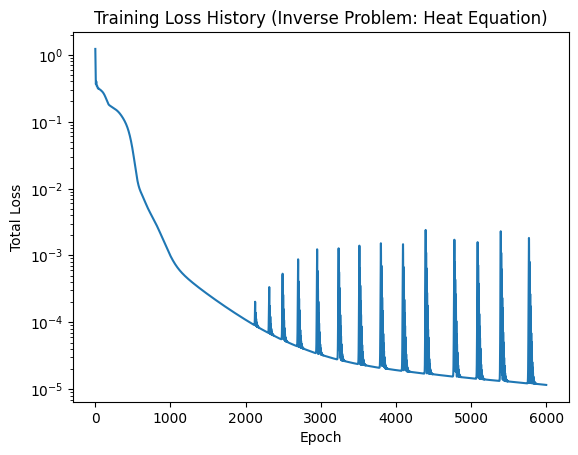

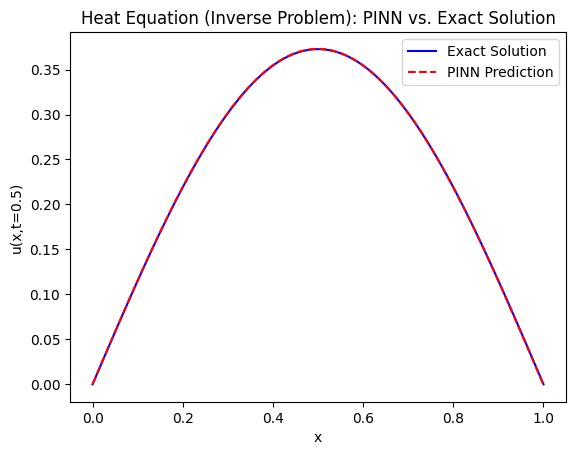

In [ ]:
"""
Inverse Problem – Identifying the Thermal Diffusivity in a 1D Heat Equation

Equation:
    u_t = α u_xx,  for (x,t) in [0,1]×[0,1]

Conditions:
    Initial: u(x,0)=sin(pi*x)
    Boundary: u(0,t)=u(1,t)=0

Exact solution (with true α = 0.2):
    u(x,t) = sin(pi*x) * exp(-α*pi^2*t)

In this inverse problem, α is treated as an unknown parameter that is estimated
using sparse measurement data of u(x,t).
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the neural network that approximates u(x,t)
class HeatPINN(nn.Module):
    def __init__(self):
        super(HeatPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = HeatPINN()

# Define the true value of α and set it as the target (for generating synthetic data)
alpha_true = 0.2

# Initialize α as a learnable parameter (starting from a guess, e.g., 0.5)
alpha = torch.tensor([0.5], dtype=torch.float32, requires_grad=True)

# Exact solution for generating measurement data and evaluation
def exact_heat_solution(x, t, alpha):
    return np.sin(np.pi * x) * np.exp(-alpha * np.pi**2 * t)

# Generate synthetic measurement data (sparse) for inverse problem
N_meas = 50
x_meas = np.random.uniform(0, 1, (N_meas, 1))
t_meas = np.random.uniform(0, 1, (N_meas, 1))
u_meas = exact_heat_solution(x_meas, t_meas, alpha_true)
# Convert to tensors
x_meas_tensor = torch.tensor(x_meas, dtype=torch.float32)
t_meas_tensor = torch.tensor(t_meas, dtype=torch.float32)
u_meas_tensor = torch.tensor(u_meas, dtype=torch.float32)

# Compute the PDE residual with learnable α
def compute_heat_residual(x, t, alpha_val):
    x.requires_grad = True
    t.requires_grad = True
    inp = torch.cat([x, t], dim=1)
    u = model(inp)
    # Time derivative
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    # Spatial derivatives
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    # Residual: u_t - α*u_xx = 0
    residual = u_t - alpha_val * u_xx
    return residual

# Additional points for PDE residual enforcement inside the domain
N_f = 1000
x_f = np.random.uniform(0, 1, (N_f, 1))
t_f = np.random.uniform(0, 1, (N_f, 1))
x_f_tensor = torch.tensor(x_f, dtype=torch.float32)
t_f_tensor = torch.tensor(t_f, dtype=torch.float32)

# Initial condition: u(x,0)=sin(pi*x)
N_ic = 200
x_ic = np.linspace(0, 1, N_ic).reshape(-1,1)
t_ic = np.zeros_like(x_ic)
u_ic = np.sin(np.pi * x_ic)
x_ic_tensor = torch.tensor(x_ic, dtype=torch.float32)
t_ic_tensor = torch.tensor(t_ic, dtype=torch.float32)
u_ic_tensor = torch.tensor(u_ic, dtype=torch.float32)

# Boundary conditions: u(0,t)=0 and u(1,t)=0
N_bc = 200
t_bc = np.linspace(0, 1, N_bc).reshape(-1,1)
x_bc_left = np.zeros_like(t_bc)
x_bc_right = np.ones_like(t_bc)
x_bc = np.vstack([x_bc_left, x_bc_right])
t_bc = np.vstack([t_bc, t_bc])
u_bc = np.zeros_like(x_bc)
x_bc_tensor = torch.tensor(x_bc, dtype=torch.float32)
t_bc_tensor = torch.tensor(t_bc, dtype=torch.float32)
u_bc_tensor = torch.tensor(u_bc, dtype=torch.float32)

# Optimizer for both the network parameters and α
optimizer = optim.Adam(list(model.parameters()) + [alpha], lr=1e-3)
epochs = 6000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Compute the PDE residual loss over collocation points
    residual = compute_heat_residual(x_f_tensor, t_f_tensor, alpha)
    loss_pde = torch.mean(residual**2)

    # Compute the data loss over the measurement points
    inp_meas = torch.cat([x_meas_tensor, t_meas_tensor], dim=1)
    u_pred_meas = model(inp_meas)
    loss_data = torch.mean((u_pred_meas - u_meas_tensor)**2)

    # Initial condition loss
    inp_ic = torch.cat([x_ic_tensor, t_ic_tensor], dim=1)
    u_pred_ic = model(inp_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic_tensor)**2)

    # Boundary condition loss
    inp_bc = torch.cat([x_bc_tensor, t_bc_tensor], dim=1)
    u_pred_bc = model(inp_bc)
    loss_bc = torch.mean(u_pred_bc**2)

    # Total loss: combine PDE residual, data mismatch, and condition losses.
    loss = loss_pde + loss_data + loss_ic + loss_bc
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} - Total Loss: {loss.item():.3e}, Data Loss: {loss_data.item():.3e}, PDE Loss: {loss_pde.item():.3e}, α: {alpha.item():.4f}")

print("Estimated α:", alpha.item())

# Plot training loss history
plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss History (Inverse Problem: Heat Equation)")
plt.show()

# Evaluation: compare PINN prediction with the exact solution for a fixed t slice (e.g., t=0.5)
x_test = np.linspace(0, 1, 100).reshape(-1,1)
t_fixed = 0.5 * np.ones_like(x_test)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
t_test_tensor = torch.tensor(t_fixed, dtype=torch.float32)
inp_test = torch.cat([x_test_tensor, t_test_tensor], dim=1)
u_pred = model(inp_test).detach().numpy().flatten()
u_exact = exact_heat_solution(x_test, 0.5, alpha_true).flatten()

plt.figure()
plt.plot(x_test, u_exact, 'b-', label="Exact Solution")
plt.plot(x_test, u_pred, 'r--', label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x,t=0.5)")
plt.title("Heat Equation (Inverse Problem): PINN vs. Exact Solution")
plt.legend()
plt.show()
